In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

# Application dataset
application_train dataset has:
* 307511 observations and 122 features
* No duplicates
* Groups of features have Null values

In [2]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')
help_tool.first_look(application_train)

Dataset has 307511 observations and 122 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
TARGET,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
CODE_GENDER,object,0,0.0
FLAG_OWN_CAR,object,0,0.0
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_WEEK,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,float64,41519,13.5


In [3]:
application_train.drop(columns=['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START'], inplace=True)

### Cleaning object features
Before feature selection for Target, object type columns must be handeled. OneHotEncoding is a not good aproach (the dataset has 16 object type features), which would result of column number explosion an would confuse the Light XGB model when fitting for feature importance.

In [4]:
application_train = help_tool.convert_flags(application_train)

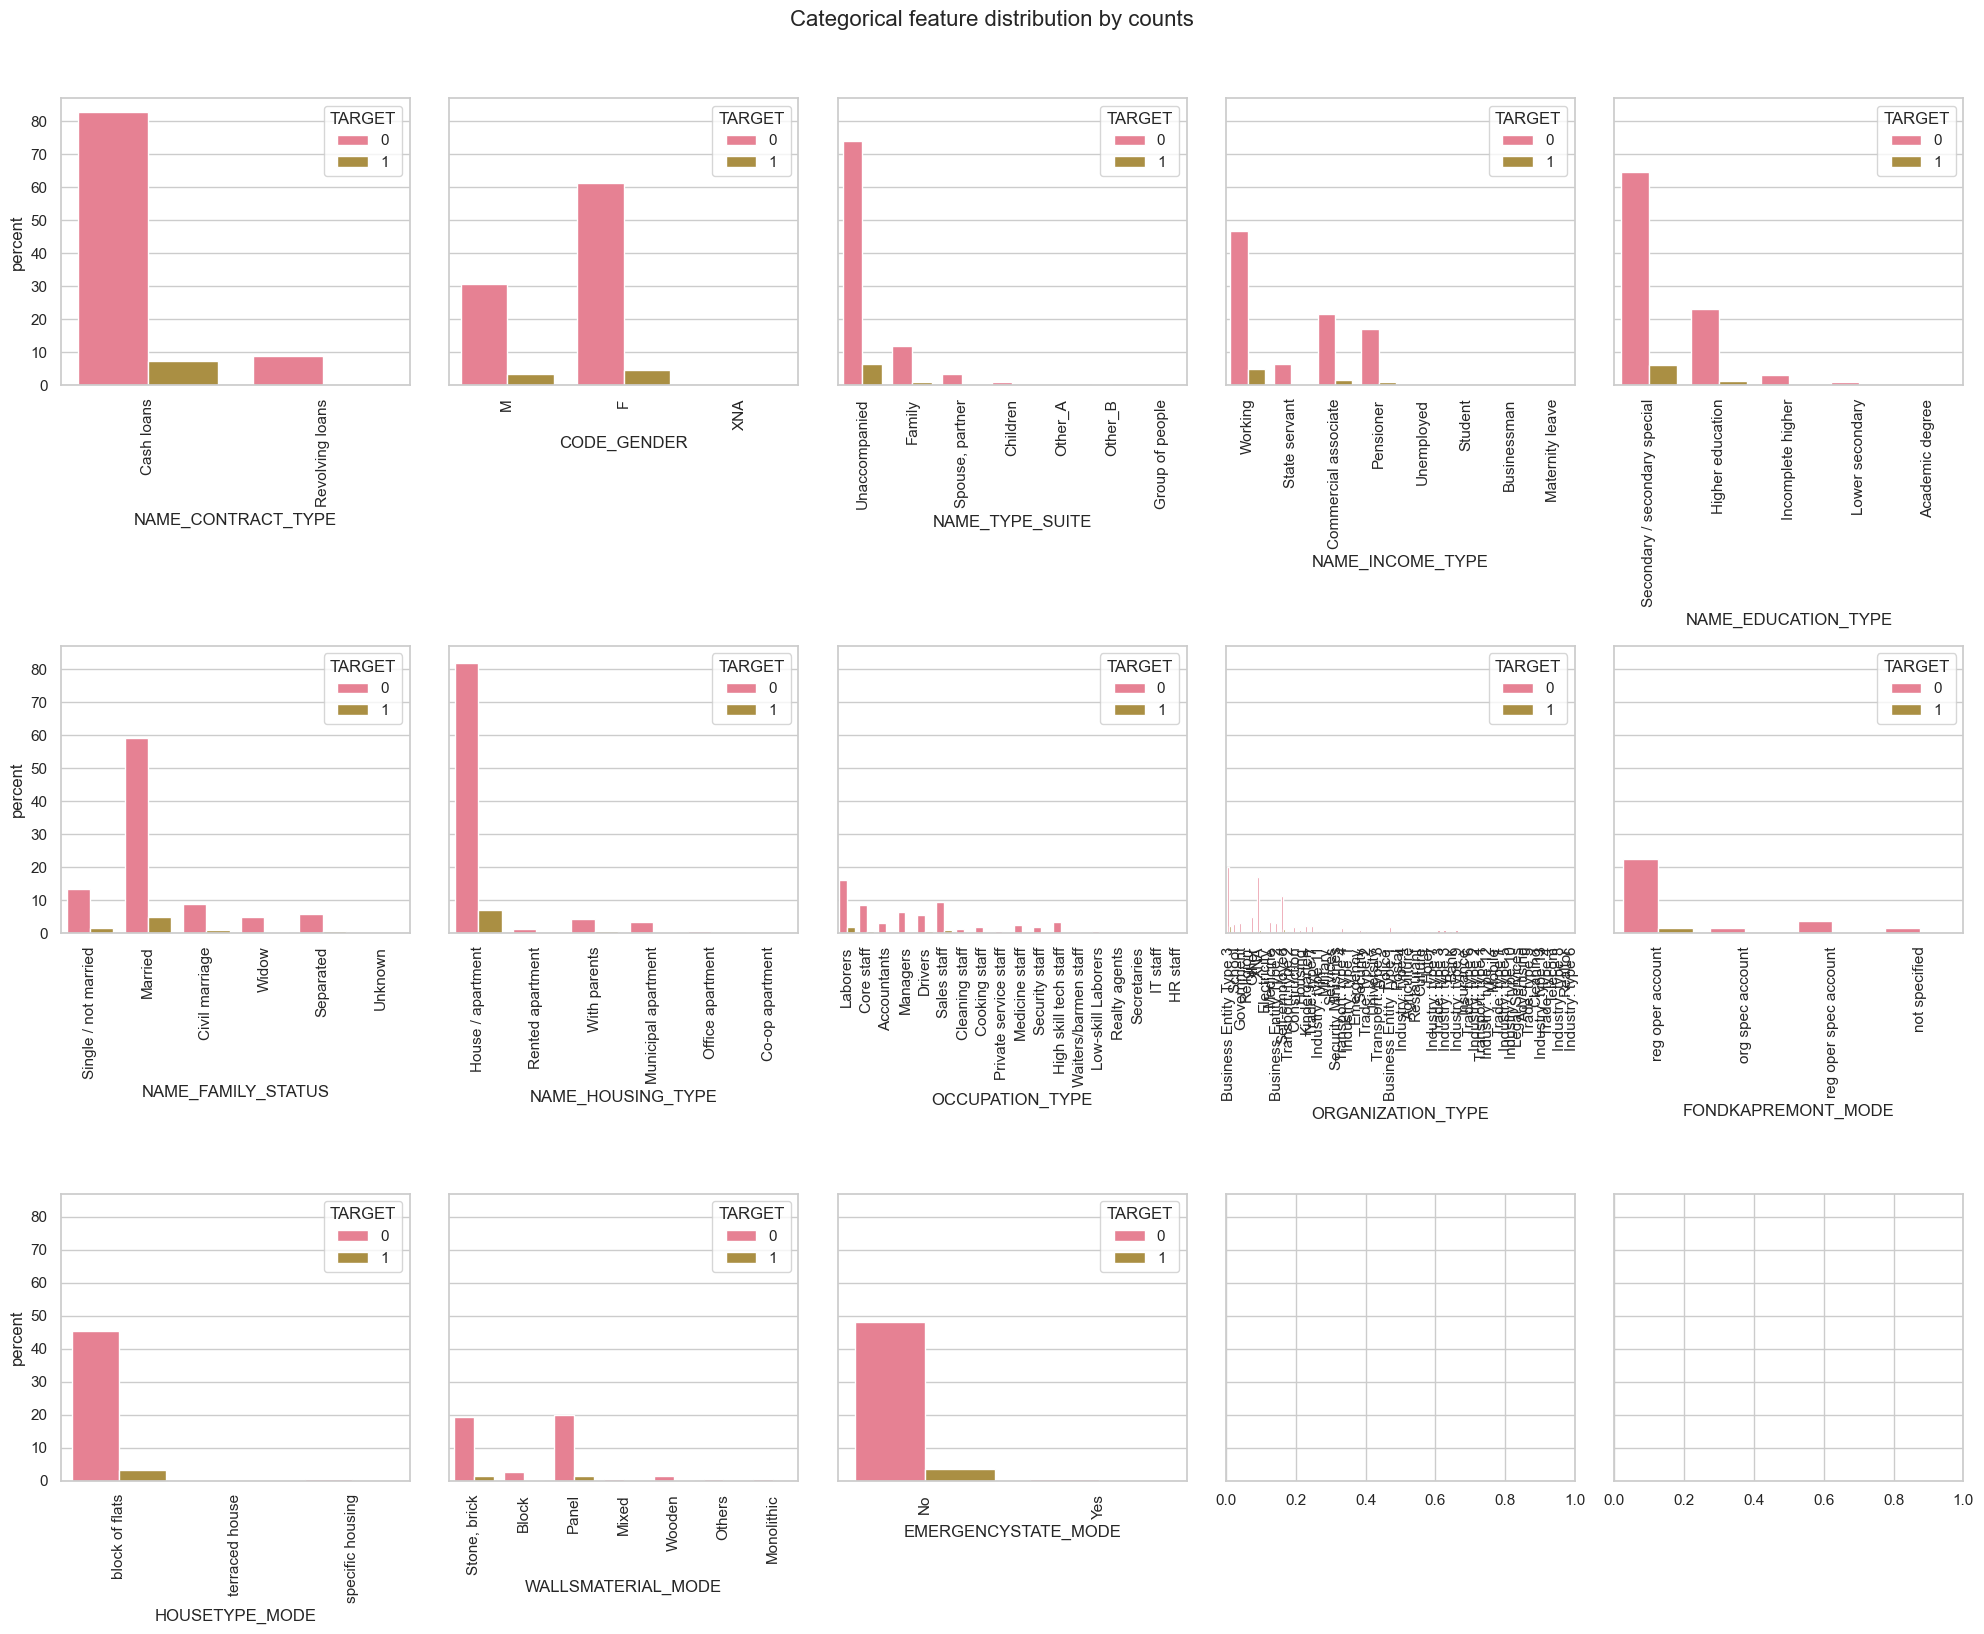

In [5]:
object_columns = application_train.select_dtypes(include=['object']).columns.tolist()

fig, axes = plt.subplots(3, 5, figsize=(20, 16), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.countplot(data=application_train, x=col, 
                 ax=axes[i],  
                 legend=True,
                 stat="percent",
                 hue='TARGET'
                 )
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

From the above plots, it is seen thecre's no object feature with a clear dependency on Target. Thus, feature will be:
* Numerically encoded when posible (Cash Loans / not Cash Loans)
* Dropping discriminatory features, which use could be prohibited by Bank Associantions (i.e. gender)
* Discrimination could be avoided by categorizing NAME_FAMILY_STATUS to single/not single.
* Education type can be numerically encoded.
* Grouped to subgroups if feature has high Cardinality (number of unique value)

Additionly, some features might be prohibited by the Banking Authorities, i.e. Gender identity, Skin Colour, Religion. For this reason, GENDER_CODE will be dropped, despite having a potential inpact on TARGET.

Null Hypothesis (H0): There is no relationship between 'CODE_GENDER' and 'TARGET'. <br>
Alternative Hypothesis (H1): There is a relationship between 'CODE_GENDER' and 'TARGET'.

In [6]:
help_stats.chi_squared_test(application_train.dropna(subset='CODE_GENDER'), ('TARGET', 'CODE_GENDER'))

Chi-squared statistic: 920.7913340361749. P-value: 1.1290217848908289e-200. Reject the null hypothesis.


Conclussion: CODE_GENDER has an impact on TARGET, but due to potential discriminatory reglaments, it will be removed.

In [7]:
application_train = help_tool.encode_categories(application_train)

Target is imbalanced, as only 8 % of clients default.

In [8]:
application_train['TARGET'].value_counts() / application_train['TARGET'].count() * 100

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

# Feature Selection
## Variance 
A lot of features have 0 or less than 0.1 variance. One of the zero variance features is TARGET. Since the dataset is imbalanced, dropping Zero variance features could result in lost information for the minority TARGET.

In [9]:
help_model.zero_variance_features(application_train)

['TARGET',
 'REGION_POPULATION_RELATIVE',
 'FLAG_MOBIL',
 'FLAG_CONT_MOBILE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI'

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

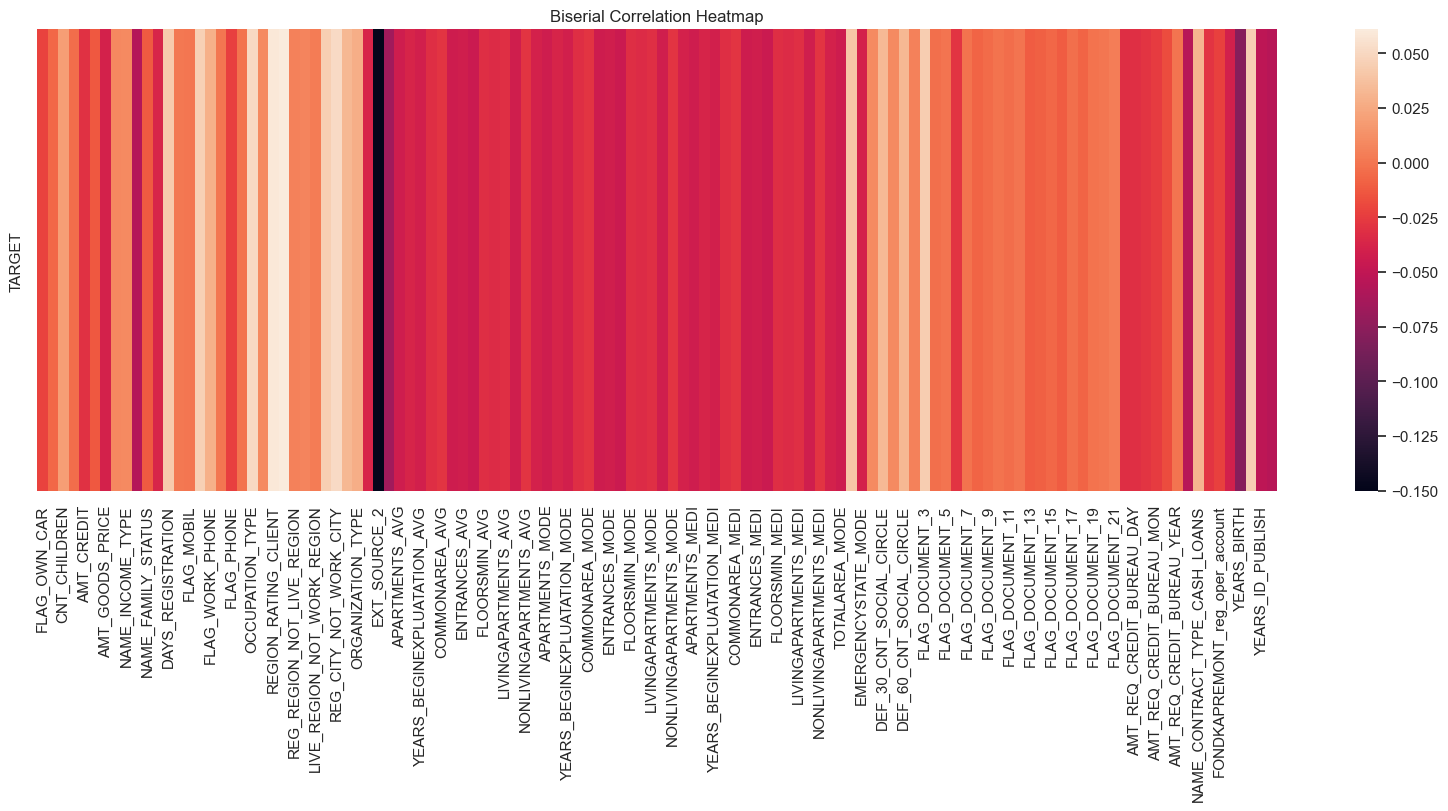

In [10]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(application_train.fillna(-1), application_train.drop(columns=['SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

## Adding previously created features

In [11]:
sub_data_clusters = help_tool.csv_download(r'Archive\home-credit-default-risk\sub_data_clusters.csv').drop(columns='Unnamed: 0')
bureau_data_clusters = help_tool.csv_download(r'Archive\home-credit-default-risk\sorted_bureau_feature_matrix.csv')[['SK_ID_CURR', 'Cluster_bureau']]

In [12]:
whole_data = duckdb.query("""
             SELECT 
                A.*, 
                B.*, 
                C.Cluster_bureau

             FROM application_train A
             LEFT JOIN sub_data_clusters B
             ON A.SK_ID_CURR = B.SK_ID_CURR
             LEFT JOIN bureau_data_clusters C
             ON A.SK_ID_CURR = C.SK_ID_CURR
             
             """).to_df().drop(columns='SK_ID_CURR_1')

In [13]:
whole_data['EXT_SOURCE_1'].isna().sum()

173378

## TRAGET

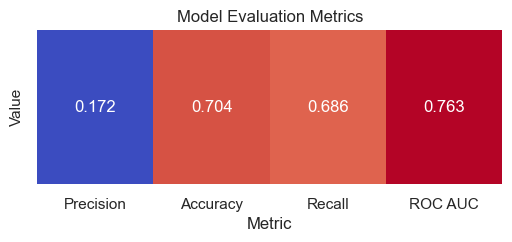

In [14]:
target_feature_importance = help_model.model_feature_importance_target(whole_data)

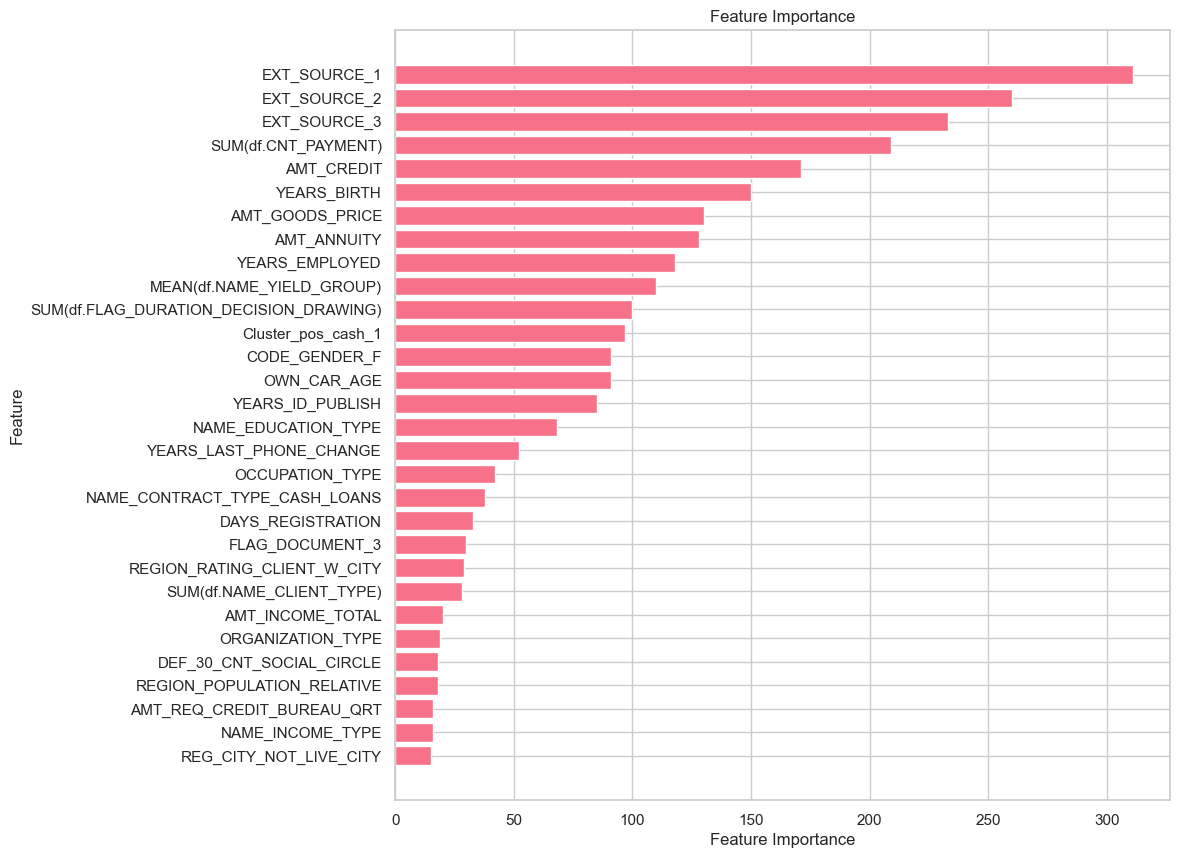

In [15]:
help_model.plot_feature_importance(target_feature_importance.head(30))

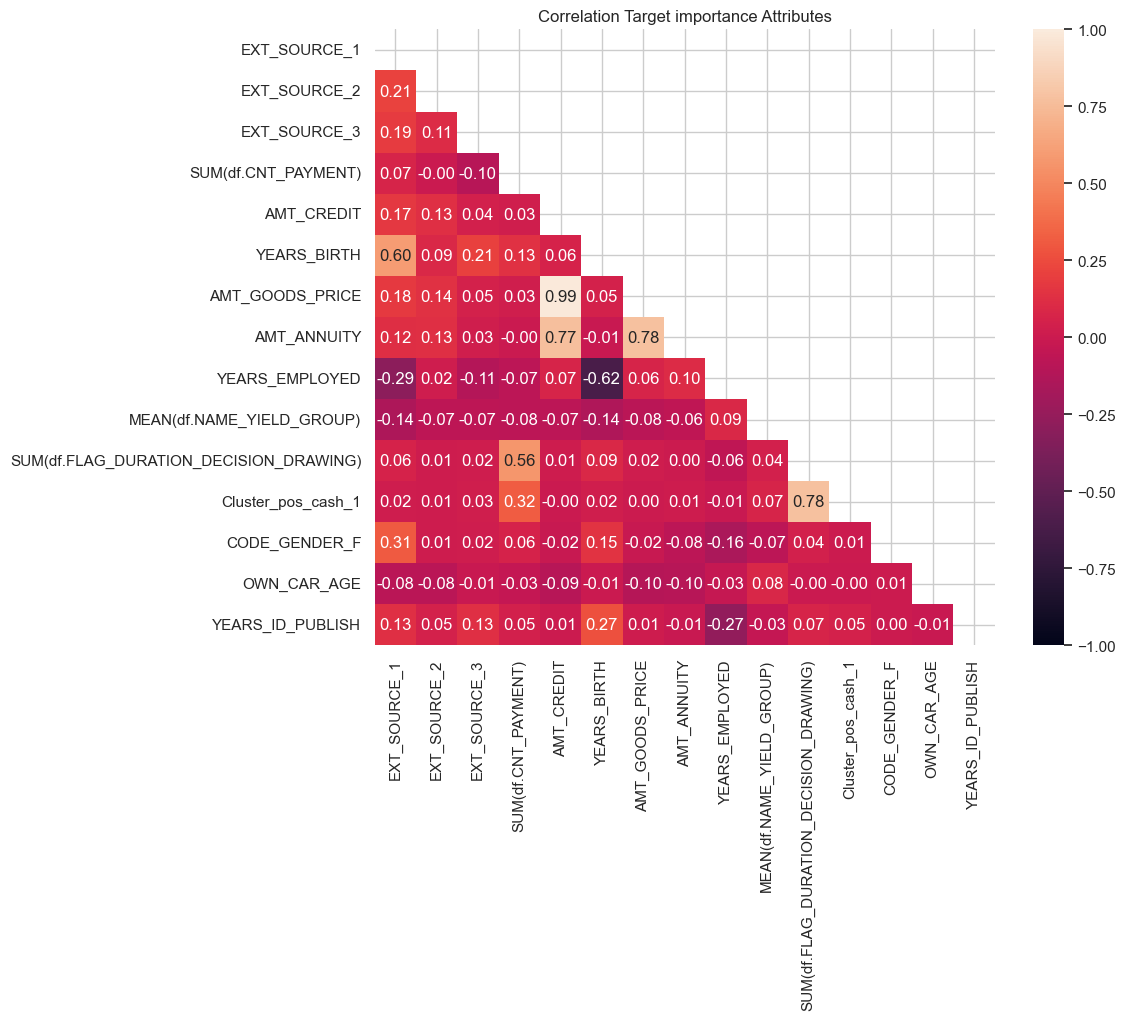

In [16]:
help_visuals.heatmap(whole_data[target_feature_importance['feature'].head(15).to_list()], 'TARGET importance', 'pearson')

In [17]:
target_features = whole_data[target_feature_importance['feature'].head(15).to_list()].drop(columns=['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'SUM(df.FLAG_DURATION_DECISION_DRAWING)']).columns.to_list()
target_features

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'SUM(df.CNT_PAYMENT)',
 'AMT_CREDIT',
 'YEARS_BIRTH',
 'YEARS_EMPLOYED',
 'MEAN(df.NAME_YIELD_GROUP)',
 'Cluster_pos_cash_1',
 'CODE_GENDER_F',
 'OWN_CAR_AGE',
 'YEARS_ID_PUBLISH']

# AVG Risk Score

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
from sklearn.model_selection import StratifiedKFold
import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import featuretools as ft
from sklearn.impute import SimpleImputer
import optuna
#from help_tool 
#import help_tool, help_visuals, help_stats, help_model
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation

import warnings

In [24]:
def model_feature_importance_exteranal(df):


    selected_data_risk_score = df.dropna(subset='MEAN(df.NAME_YIELD_GROUP)').sample(10000, random_state=42)
    selected_data_risk_score.drop_duplicates(inplace=True)

    X = selected_data_risk_score.drop(columns=['TARGET', 'MEAN(df.NAME_YIELD_GROUP)', 'SUM(df.NAME_YIELD_GROUP)'])
    y = selected_data_risk_score['MEAN(df.NAME_YIELD_GROUP)']


    (X_train, X_test, y_train, y_test) = train_test_split(
        X, y, test_size=0.3, random_state=42)

    numerical_features = X.select_dtypes(include=['number']).columns.tolist()

    # Preprocessing for numerical data
    numerical_transformer = StandardScaler()


    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            #('cat', categorical_transformer, categorical_features)
        ])

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'verbose': 0,
    }

    # Define the model
    model = LGBMRegressor(**params, n_estimators=100)

    # Create and evaluate the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the metrics in a dictionary
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

    # Reshape the DataFrame to have a single row
    metrics_df = metrics_df.set_index('Metric').T

    # Plot the heatmap with annotations
    plt.figure(figsize=(6, 2))
    sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
    plt.title("Model Evaluation Metrics")
    plt.show()

    # Extract feature importance
    model = pipeline.named_steps['model']
    feature_importances = model.feature_importances_

    # Get the feature names from the preprocessor
    feature_names = numerical_features #+ list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

    # Create a DataFrame for feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })

    # Sort the DataFrame by importance
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    return feature_importance



In [29]:
whole_data['NAME_CONTRACT_TYPE_CASH_LOANS']

0         1.0
1         1.0
2         1.0
3         1.0
4         0.0
         ... 
307506    1.0
307507    1.0
307508    1.0
307509    1.0
307510    1.0
Name: NAME_CONTRACT_TYPE_CASH_LOANS, Length: 307511, dtype: float64

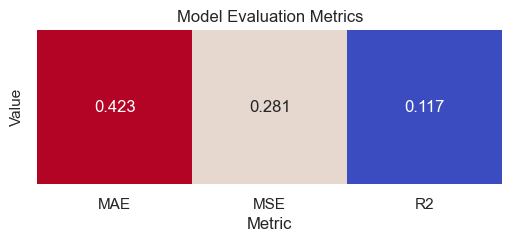

In [30]:
risk_score_feature_importance = model_feature_importance_exteranal(whole_data[whole_data['NAME_CONTRACT_TYPE_CASH_LOANS'] == 1])

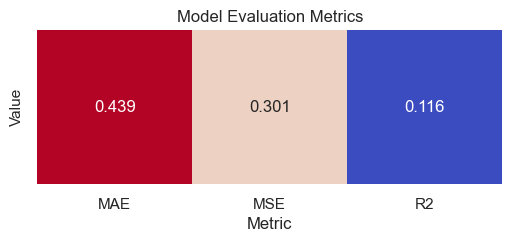

In [31]:
risk_score_feature_importance = model_feature_importance_exteranal(whole_data[whole_data['NAME_CONTRACT_TYPE_CASH_LOANS'] == 0])

In [ ]:
whole_data['HOUSING_TYPE_House']

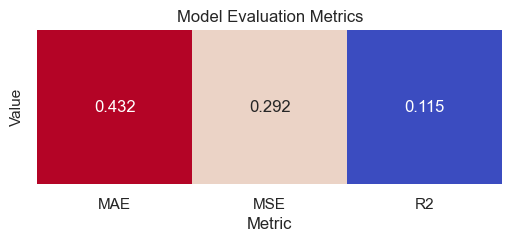

In [34]:
risk_score_feature_importance = model_feature_importance_exteranal(whole_data[whole_data['HOUSING_TYPE_House'] == 1])

Is there a significant relationship with any feature?

In [36]:
whole_data.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE',
       'MEAN(df.NAME_YIELD_GROUP)', 'SUM(df.FLAG_DURATION_DECISION_DRAWING)',
       'SUM(df.NAME_CLIENT_TYPE)', 'Cluster_pos_cash_1',
       'Cluster_installments_payments_0', 'SUM(df.CNT_PAYMENT)',
       'SUM(df.NAME_YIELD_GROUP)', 'Cluster_bureau'],
      dtype='object', length=128)

In [41]:
for i in whole_data.columns:
    help_stats.significance_t_test(whole_data, 'SUM(df.NAME_YIELD_GROUP)', i,
                        whole_data[i].min(), whole_data[i].max())

p-value = nan between SUM(df.NAME_YIELD_GROUP) and SK_ID_CURR. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and TARGET. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and FLAG_OWN_CAR. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and FLAG_OWN_REALTY. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and CNT_CHILDREN. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and AMT_INCOME_TOTAL. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and AMT_CREDIT. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and AMT_ANNUITY. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and AMT_GOODS_PRICE. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIELD_GROUP) and NAME_TYPE_SUITE. Fail to reject null hypothesis
p-value = nan between SUM(df.NAME_YIEL

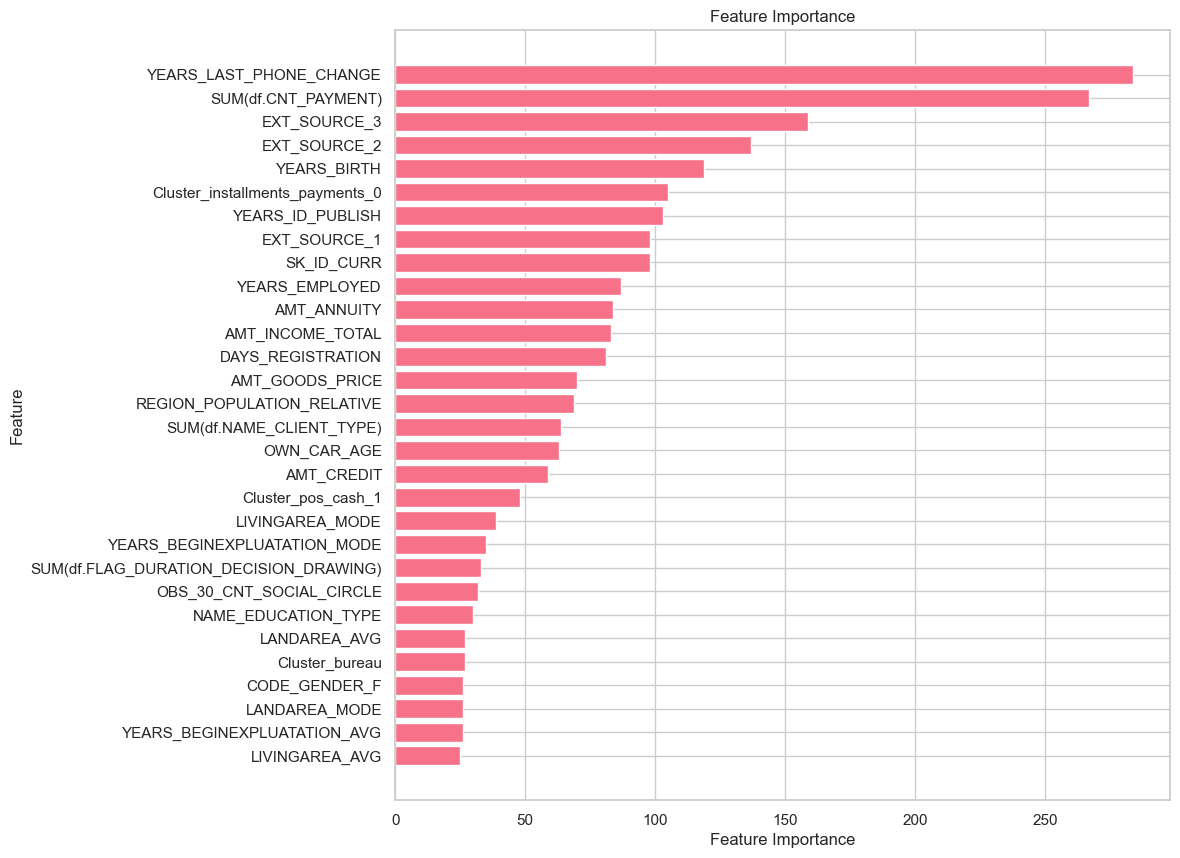

In [26]:
help_model.plot_feature_importance(risk_score_feature_importance.head(30))

## EXT_SOURCE_1

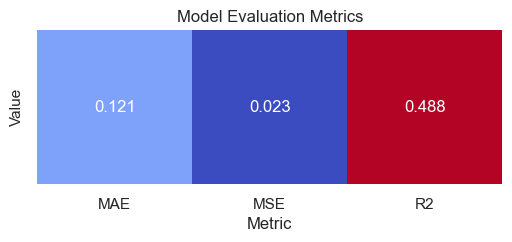

In [89]:
ext_source_1_feature_importance = help_model.model_feature_importance_exteranal(whole_data)

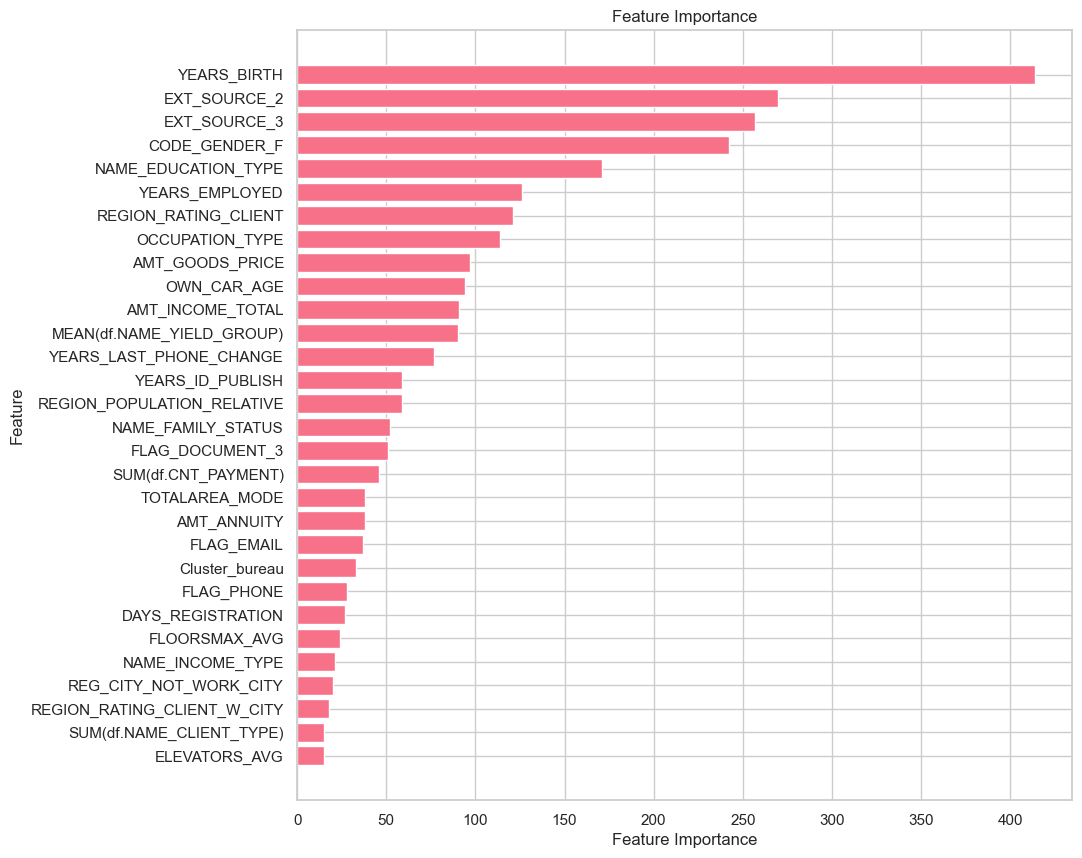

In [90]:
help_model.plot_feature_importance(ext_source_1_feature_importance.head(30))

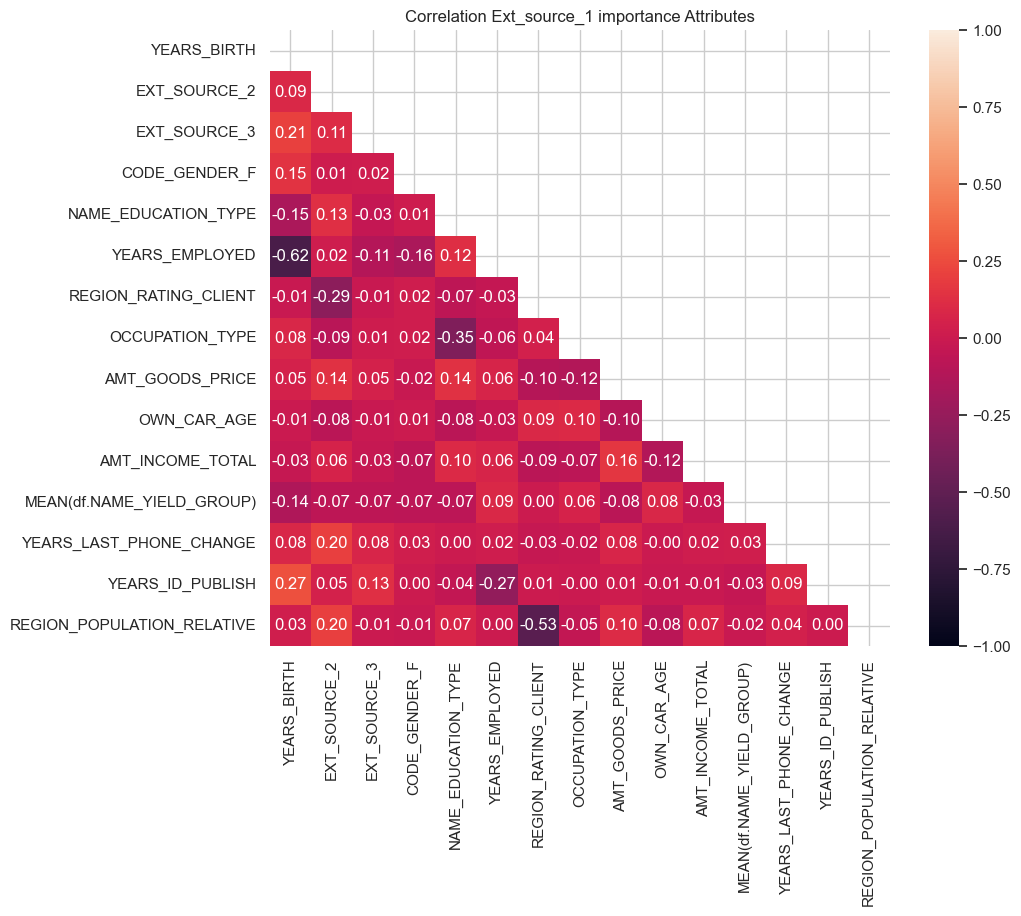

In [91]:
help_visuals.heatmap(whole_data[ext_source_1_feature_importance['feature'].head(15).to_list()], 'EXT_SOURCE_1 importance', 'pearson')

In [92]:
ext_source_1_features = whole_data[ext_source_1_feature_importance['feature'].head(15).to_list()].columns.to_list()

In [93]:
selected_features = list(set(target_features + ext_source_1_features)) + ['TARGET']

selected_data = whole_data[selected_features].rename(columns={'MEAN(df.NAME_YIELD_GROUP)': 'AVG_Risk_Score'})

selected_data.to_csv(r'Archive\home-credit-default-risk\selected_data.csv')